# Classification: Distances

Exploring euclidean distances between facial points caputred by nuiCapture as candidate features.
<p>
    <img src="nuicapture.png">
    <em>Source: CadavidConcepts</em>
</p>

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def labelname(file_name):
    label = file_name.replace("data/points/sample", "").lower()
    return label.replace(".mat", "")


class Signal:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

def dst(sig, points):
    frame_x = np.split(sig.x, 5, axis=1)
    frame_y = np.split(sig.y, 5, axis=1)
    
    nframes, nrecs, idx = np.shape(frame_x)
    eucdist = np.zeros((nframes, nrecs))
    p = points[0]
    q = points[1]
    
    for f in range(nframes):
        for r in range(nrecs):
            u = frame_x[f][r][p], frame_y[f][r][p]
            v = frame_x[f][r][q], frame_y[f][r][q]
            eucdist[f][r] = distance.euclidean(u, v)
    
    return eucdist.transpose()

## Dataset preparation

In [3]:
files = gl.glob("data/points/*.mat")  # type: list
signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

n_signs = len(signals)
n_recs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features
n_frames = 5

# arbitrarily defined points, refer to notebook 'Distances'
points = [[6, 3], [6, 11], [65, 32], [8, 9], [49, 16], [50, 17], [91, 92], [20, 25], [53, 58]]
n_points, n_dim = np.shape(points)

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {}  # Dictionary of signals' labels, for reference
i = 0

for s in signals:
    distances = []
    for p in points:
        distances.append(dst(s, p))     
    signals_feat.append(np.hstack(distances))
    signals_labels.append([i] * n_recs)
    labels_dict[i] = s.label
    i += 1

sig_features = np.vstack(signals_feat)
np.savetxt("distances.csv",sig_features,delimiter=",")
sig_labels = np.reshape(signals_labels, (n_signs * n_recs,))
np.savetxt("distances-labels.csv",sig_labels,delimiter=",")

## Classification

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

In [5]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [6]:
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(confusion_matrix(test_y, predictions, labels=test_y))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.values())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))

Iteration::  0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


Iteration::  1
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


Iteration::  2
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


Iteration::  3
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


Iteration::  4
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


Iteration::  5
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


Iteration::  6
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Iteration::  7
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  8
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


Iteration::  9
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  10
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  11
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


Iteration::  12
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  13
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  14
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  15
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  16
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  17
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  18
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  19
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


Iteration::  20
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  21
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Iteration::  22
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Iteration::  23
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Iteration::  24
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


Iteration::  25
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Iteration::  26
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Iteration::  27
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Iteration::  28
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  29
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


## Results

In [7]:
np.savetxt("dsttrainacc.csv",train_acc,delimiter=",")
np.savetxt("dsttestacc.csv",test_acc,delimiter=",")

In [8]:
np.savetxt('dstselected_params.txt',selected_params,fmt='%s',delimiter='\n')
np.savetxt("dstclassreport.txt",class_report,fmt='%s',delimiter='\n')

import pickle
with open('dstcm.txt', 'wb') as fp:
    pickle.dump(cm, fp)
with open('dstfeatimportance.txt', 'wb') as fp:
    pickle.dump(feature_importance, fp)

<IPython.core.display.Javascript object>


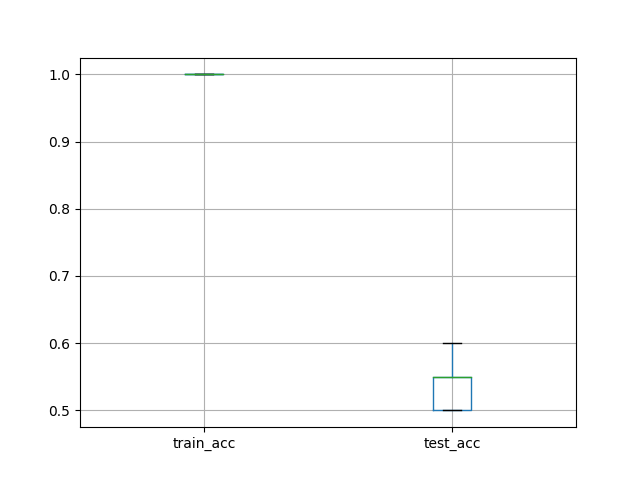

In [9]:
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [10]:
acc.describe()

,train_acc,test_acc
count,30.0,30.000000
mean,1.0,0.530000
std,0.0,0.031073
min,1.0,0.500000
25%,1.0,0.500000
50%,1.0,0.550000
75%,1.0,0.550000
max,1.0,0.600000
